In [1]:
import numpy as np
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

In [3]:
IMAGE_WIDTH = 180
IMAGE_HEIGHT = 180
IMAGE_CHANNELS = 3
DATASET_DIR = "./dataset/"
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
NUM_CLASSES = 2
EPOCHS = 50

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR + "train", 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    seed=645)

class_names = train_ds.class_names

Found 5032 files belonging to 2 classes.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR + "val", 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    seed=845)

Found 200 files belonging to 2 classes.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR + "test", 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size = BATCH_SIZE,
    seed=321)

Found 624 files belonging to 2 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [113]:
vgg = keras.applications.VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
vgg.get_layer('block1_conv1').trainable = False
vgg.get_layer('block1_conv2').trainable = False
vgg.get_layer('block2_conv1').trainable = False
vgg.get_layer('block2_conv2').trainable = False
vgg.get_layer('block3_conv1').trainable = False
vgg.get_layer('block3_conv2').trainable = False
vgg.get_layer('block3_conv3').trainable = False

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.experimental.preprocessing.RandomRotation(15)(x)
x = layers.experimental.preprocessing.RandomFlip(mode="horizontal")(x)
x = layers.experimental.preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15)(x)

x = vgg(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_8 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_8 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 12800)             0  

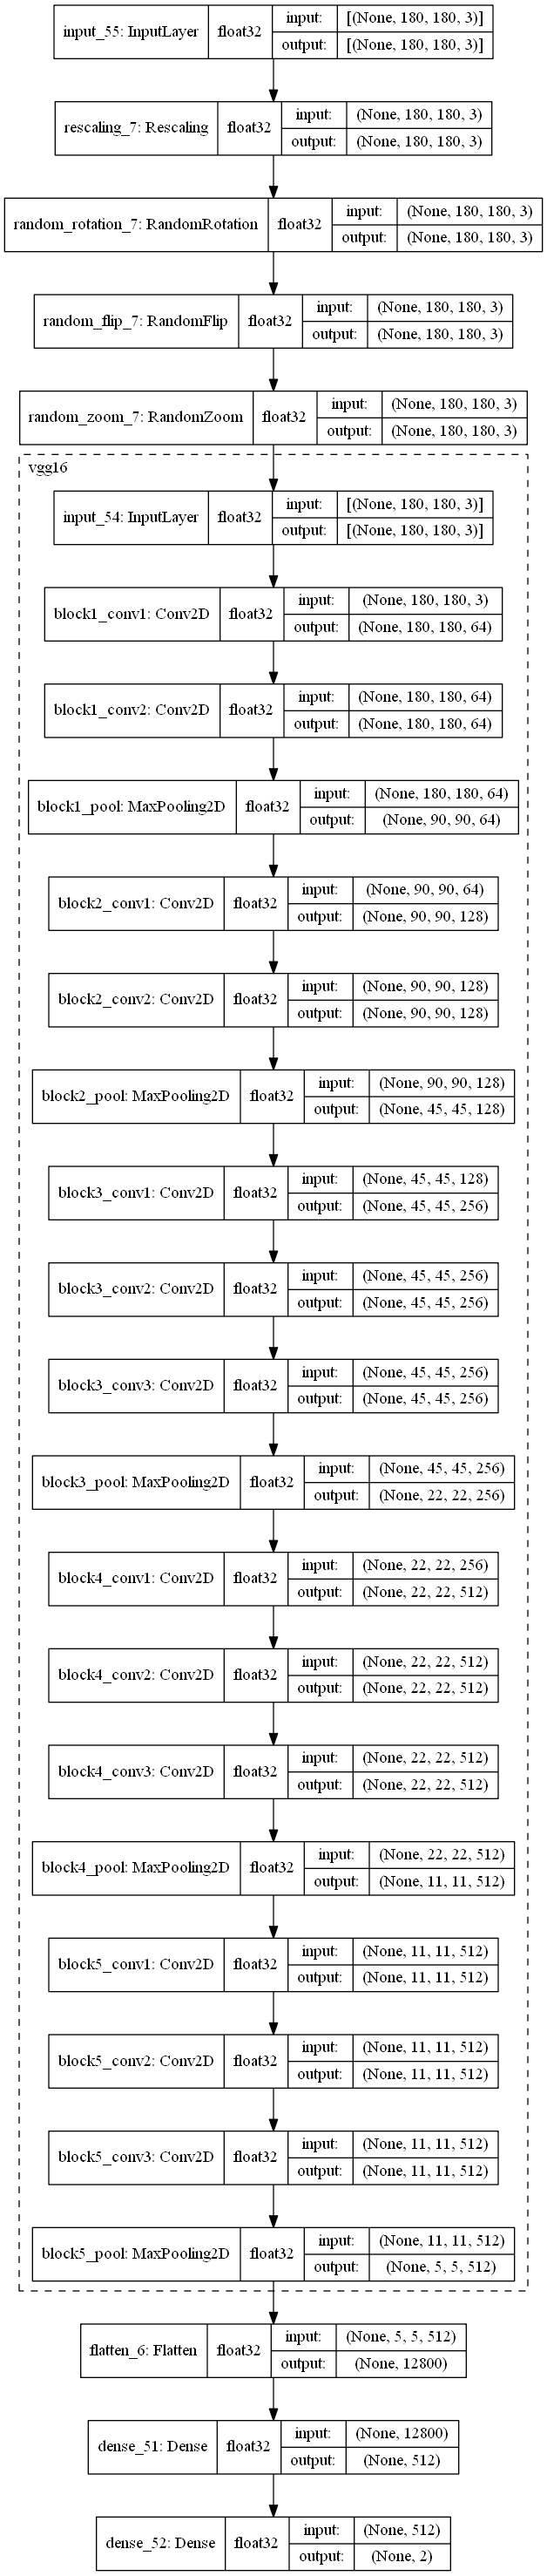

In [112]:
tf.keras.utils.plot_model(
    model,
    to_file="vgg_transfer.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [116]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(train_ds,
          validation_data=val_ds,
          callbacks=[early_stopping_monitor],
          epochs=10)

Epoch 1/10
 73/158 [============>.................] - ETA: 51s - loss: 0.7741 - accuracy: 0.2757

KeyboardInterrupt: 

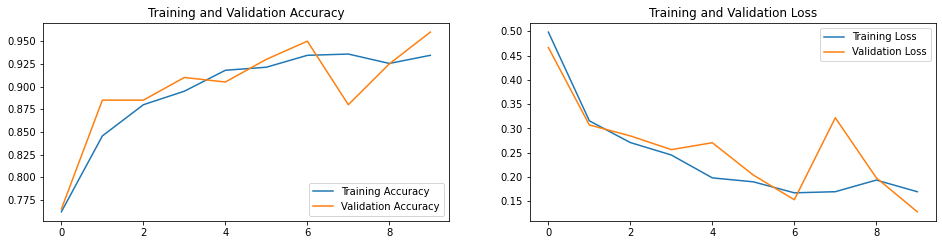

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [115]:
model.evaluate(test_ds)

20/20 [==============================] - 7s 281ms/step - loss: 0.2199 - accuracy: 0.9327


[0.21991154551506042, 0.932692289352417]

In [102]:
model.save("vgg_transfer")

INFO:tensorflow:Assets written to: vgg_transfer\assets
